In [1]:
%matplotlib inline

In [1]:
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import *
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension

from IPython.display import clear_output

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.utils import QuantumInstance
from qiskit import BasicAer, Aer
from qiskit.circuit import QuantumCircuit

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC

from time import time
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt

In [2]:
def read_data(datafile, labelindex):
    data_file = open(datafile)
    datalines = data_file.readlines()
    database = []
    labels = []
    all_labels = set()
    for data in datalines[1:]:
        feature_vector = list(data.strip().split(","))
        try:
            database.append(list(map(float, feature_vector[:labelindex] + feature_vector[labelindex+1:])))
        except:
            continue
        if feature_vector[labelindex] == "0":
            feature_vector[labelindex] = "0"
        else:
            feature_vector[labelindex] = "1"
        labels.append(feature_vector[labelindex])
        all_labels.add(feature_vector[labelindex])
    label_encodings = {d:i for i,d in enumerate(all_labels)}
    encoded_labels = [label_encodings[label] for label in labels]
    return np.array(database), np.array(encoded_labels)

In [3]:
def toy_data(set_num):
    dsize = 300
    x = np.random.random(dsize)
    y = np.random.random(dsize)    

    if set_num == 0:
        database = list(zip(x,y))
        labels = [0 if x[i] > y[i] else 1 for i in range(dsize)]
        x1 = []
        y1 = []
        x2 = []
        y2 = []
        for i in range(dsize):
            if labels[i] == 0:
                x1.append(x[i])
                y1.append(y[i])
            else:
                x2.append(x[i])
                y2.append(y[i])
        plt.figure(figsize=(6,4))
        plt.scatter(x1, y1, color='r', label='Class 0')
        plt.scatter(x2, y2, color='b', label='Class 1')
        plt.title('Dataset 0')
        plt.legend(bbox_to_anchor = (1.25, 0.5), loc='center right')
        plt.savefig("Figures/data_0", bbox_inches='tight')

    elif set_num == 1:
        database = list(zip(x, y))
        labels = [0 if (x[i]- 0.5)**2 + (y[i]-0.5)**2 < 0.1225 else 1 for i in range(dsize)]       

        x1 = []
        y1 = []
        x2 = []
        y2 = []
        for i in range(dsize):
            if labels[i] == 0:
                x1.append(x[i])
                y1.append(y[i])
            else:
                x2.append(x[i])
                y2.append(y[i])
        plt.figure(figsize=(6,5))
        plt.scatter(x1, y1, color='r', label='Class 0')
        plt.scatter(x2, y2, color='b', label='Class 1')
        plt.title('Dataset 1')
        plt.legend(bbox_to_anchor = (1.25, 0.5), loc='center right')
        plt.savefig("Figures/data_1", bbox_inches='tight')
        plt.show()
    
    elif set_num == 2:
        database = list(zip(x, y))
        labels = [0 if np.sin(x[i])*np.sin(y[i]) < 0.1 or np.sin(x[i])*np.sin(y[i]) > 0.3 else 1 for i in range(dsize)]   

        x1 = []
        y1 = []
        x2 = []
        y2 = []
        for i in range(dsize):
            if labels[i] == 0:
                x1.append(x[i])
                y1.append(y[i])
            else:
                x2.append(x[i])
                y2.append(y[i])
        plt.figure(figsize=(6,5))
        plt.scatter(x1, y1, color='r', label='Class 0')
        plt.scatter(x2, y2, color='b', label='Class 1')
        plt.title('Dataset 2')
        plt.legend(bbox_to_anchor = (1.25, 0.5), loc='center right')
        plt.savefig("Figures/data_2", bbox_inches='tight')
        plt.show()
    
    elif set_num == 3:
        z = np.random.random(dsize)
        database = list(zip(x, y, z))
        labels = [0 if x[i]*y[i] + z[i] > 0.5 else 1 for i in range(dsize)]   
    
    elif set_num == 4:
        z = np.random.random(dsize)
        w = np.random.random(dsize)
        database = list(zip(x, y, z, w))
        labels = [0 if x[i]*y[i] + z[i]*w[i] > 0.5 else 1 for i in range(dsize)]   
    
    else:
        print("Error: Incorrect number")
        return

    return np.array(database), np.array(labels)

In [31]:
class classify:        
    def __init__(self, datafile=None, labelindex=None, amp_encoded=False, toy=False):
        if datafile:
            self.database, self.labels = read_data(datafile, labelindex)
        else:
            self.database, self.labels = toy_data(toy)
        self.feature_dim = self.database.shape[1]
        self.amp_encoded = amp_encoded
        if self.amp_encoded:
            nq = int(np.ceil(np.log2(self.feature_dim)))
            self.database= np.pad(self.database, ((0,0),(0,2**nq - self.feature_dim)), mode="constant", constant_values=0)
            self.feature_dim = nq
        self.classifier = None
        self.ct = None
    
    def split(self, train_size=0.8, random_state=42):
        return train_test_split(self.database, self.labels, train_size=train_size, random_state=random_state)
    
    def kernel_qsvc(self, feature_map=None, seed=1376):
        if feature_map is None:
            feature_map = ZFeatureMap(self.feature_dim)

        kernel = QuantumKernel(feature_map=feature_map,
                                    quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                                    shots=1,
                                                    seed_simulator=seed,
                                                    seed_transpiler=seed))

        # print("Feature Map : ", kernel.feature_map.decompose())
        # print("Kernel matrix : ", kernel.evaluate(self.database, self.labels))
        self.classifier = QSVC(quantum_kernel=kernel)
        self.ct = 'qsvc'
    
    def kernel_qnn(self, feature_map=None, seed=1376):
        if feature_map is None:
            feature_map = ZFeatureMap(self.feature_dim)
        
        ansatz = RealAmplitudes(num_qubits=self.feature_dim, reps=1)
        qbase = QuantumCircuit(self.feature_dim)
        qbase.compose(feature_map, inplace=True)
        qbase.compose(ansatz, inplace=True)

        # print("Initiating Qiskit Runtime Service...", end=" ")
        # service = QiskitRuntimeService(
        #     channel='ibm_quantum',
        #     instance='ibm-q/open/main',
        # )

        # print("Qiskit Runtime Service initiated")
        # print("Assigning backend...", end=" ")
        # backend = service.backend('simulator_statevector')

        # print(Aer.backends())
        backend = Aer.get_backend('statevector_simulator')
        print(type(backend))
        sampler = Sampler(backend)
        print(f"{sampler.session} assigned")

        def parity(x):
            return "{:b}".format(x).count("1") % 2
        output_shape = 2

        qnet = SamplerQNN(circuit=qbase, input_params=feature_map.parameters, weight_params=ansatz.parameters, interpret=parity, output_shape=output_shape, sampler=sampler)
        display(qnet.circuit.decompose().draw('mpl'))

        def callback_graph(weights, obj_func_eval):
            clear_output(wait=True)
            objective_func_vals.append(obj_func_eval)
            plt.title("Objective function value against iteration")
            plt.xlabel("Iteration")
            plt.ylabel("Objective function value")
            plt.plot(range(len(objective_func_vals)), objective_func_vals)
            plt.show()

        self.classifier = NeuralNetworkClassifier(neural_network=qnet, optimizer=COBYLA(maxiter=50), callback=callback_graph)        
        self.ct = 'qnn'

    def csvc(self, kernel="rbf", gamma="scale", seed=1376):
        csvc1 = SVC(kernel=kernel, gamma=gamma, random_state=seed)
        self.classifier = csvc1

    def train(self, train_data, train_labels):
        start = time()
        self.classifier.fit(train_data, train_labels)
        end = time()
        if self.ct == 'qnn':
            return end-start, self.classifier.weights
        return end-start
    
    def predict(self, test_data):
        start = time()
        pred_labels = self.classifier.predict(test_data)
        end = time()
        return pred_labels, end-start
    
    def get_scores(self, test_labels, pred_labels):
        acc =  accuracy_score(test_labels, pred_labels)
        prec = precision_score(test_labels, pred_labels, average="macro")
        recall = recall_score(test_labels, pred_labels, average="macro")
        f1 = f1_score(test_labels, pred_labels, average="macro")

        print("Accuracy: ", acc)
        print("Precision: ", prec)
        print("Recall: ", recall)
        print("F1: ", f1)
        print()

        return acc, prec, recall, f1

## Kernels

In [5]:
def eq_8(x):
    # for k = 1
    phi = x[0]
    return (np.pi/2)*phi

def eq_8_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else x[0]*x[1]
    return (np.pi/2)*phi

def eq_8_3(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else x[0]*x[1]*x[2]
    return (np.pi/2)*phi

In [6]:
def eq_9(x):
    # for k = 1
    phi = 1 - x[0]
    return (np.pi/2)*phi

def eq_9_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else (1-x[0])*(1-x[1])
    return (np.pi/2)*phi

def eq_9_2(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else (1-x[0])*(1-x[1])*(1-x[2])
    return (np.pi/2)*phi

In [7]:
def eq_10(x):
    # for k = 1
    phi = np.exp(np.square(x[0])/8)
    return np.pi*phi

def eq_10_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else np.exp(np.square(x[0] - x[1])/8)
    return np.pi*phi

def eq_10_2(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else np.exp(np.square(x[0] - x[1])/8) + np.exp(np.square(x[1] - x[2])/8) + np.exp(np.square(x[2] - x[0])/8)
    return np.pi*phi

In [8]:
def eq_11(x):
    # for k = 1
    phi = 1/np.cos(x[0])
    return (np.pi/3)*phi

def eq_11_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else 1/np.cos(x[0])*1/np.cos(x[1])
    return (np.pi/3)*phi

def eq_11_2(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else 1/np.cos(x[0])*1/np.cos(x[1])*1/np.cos(x[2])
    return (np.pi/3)*phi

In [9]:
def eq_12(x):
    # for k = 1
    phi = np.cos(x[0])
    return np.pi*phi

def eq_12_1(x):
    # for k = 2
    phi = x[0] if len(x) == 1 else np.cos(x[0])*np.cos(x[1])
    return np.pi*phi

def eq_12_2(x):
    # for k = 3
    phi = x[0] if len(x) == 1 else np.cos(x[0])*np.cos(x[1])*np.cos(x[2])
    return np.pi*phi

## CNN

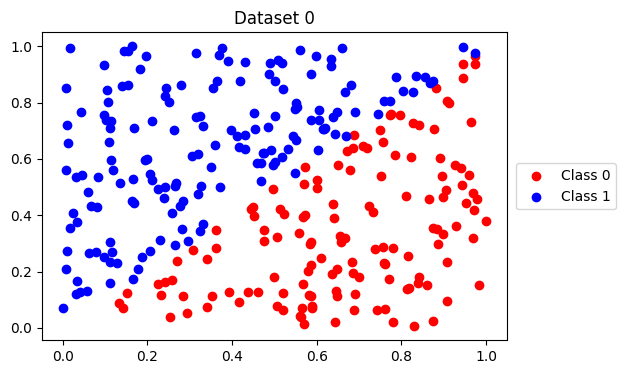

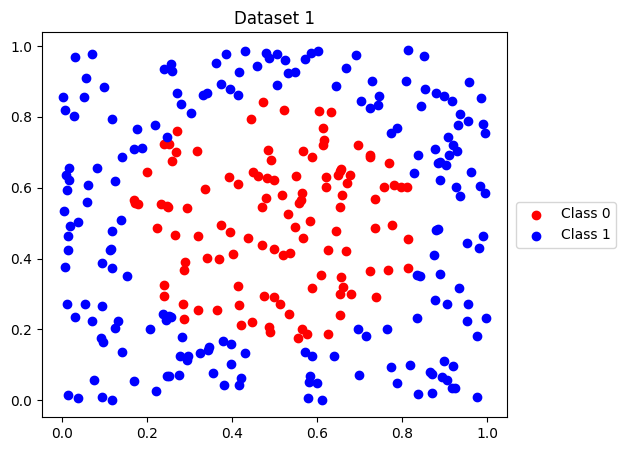

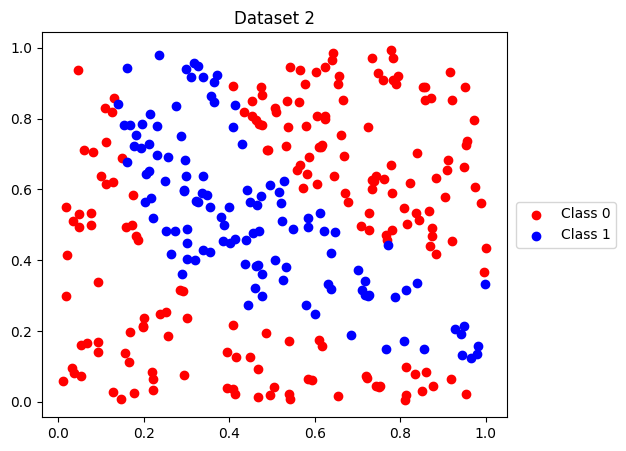

[1.0, 0.62, 0.5766666666666667, 0.9966666666666667, 0.6033333333333334]


In [10]:
from sklearn.neural_network import MLPClassifier

cnn_acc = []
for i in range(5):
    sc = 0
    X, y = toy_data(i)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500, hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(X, y)
    cnn_acc.append(clf.score(X, y))
print(cnn_acc)

## QNN

In [27]:
def qnn_encoding(paulis, func=None, datafile=None, dim=None, write_scores=False, toy=False):
    if datafile:
        folder = datafile[0]
        qc = classify(datafile, dim, False, False)
    else:
        folder = "T" + str(toy)
        qc = classify(None, None, False, toy)
    
    # train_data, test_data, train_labels, test_labels = qc.split()
    train_data = qc.database
    train_labels = qc.labels
    test_data = qc.database
    test_labels = qc.labels

    if func:
        fm = PauliFeatureMap(qc.feature_dim, data_map_func=func, paulis=paulis)
        qc.kernel_qnn(feature_map=fm)
    else:
        fm = PauliFeatureMap(qc.feature_dim, paulis=paulis)
        qc.kernel_qnn()
    print()

    print("Training...", end=" ")
    traintime, wts = qc.train(train_data, train_labels)
    print("Training complete. Training time: ", traintime)
    print("Testing...", end=" ")
    pred_labels, testime = qc.predict(test_data)
    print(confusion_matrix(test_labels, pred_labels))
    print("Testing complete. Testing time: ", testime)
    score = qc.get_scores(test_labels, pred_labels)

    if write_scores:
        af = open(f"{folder}/Acc.txt", "a")
        af.write(f"{score[0]}, ")
        af.close()

        pf = open(f"{folder}/Prec.txt", "a")
        pf.write(f"{score[1]}, ")
        pf.close()

        rf = open(f"{folder}/Rec.txt", "a")
        rf.write(f"{score[2]}, ")
        rf.close()

        ff = open(f"{folder}/F1.txt", "a")
        ff.write(f"{score[3]}, ")
        ff.close()

        trainf = open(f"{folder}/TrainTime.txt", "a")
        trainf.write(f"{traintime}, ")
        trainf.close()

        testf = open(f"{folder}/TestTime.txt", "a")
        testf.write(f"{testime}, ")
        testf.close()
    return wts, qc.classifier, qc.database

In [28]:
def qnn_ged(wts, nnc, dataset, toy):
    global_ed = EffectiveDimension(qnn=nnc.neural_network, weight_samples=len(wts), input_samples=10)
    global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=len(dataset))
    print("Data size: {}, global effective dimension: {:.4f}".format(len(dataset), global_eff_dim_0))
    d = nnc.neural_network.num_weights
    print("Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d))
    ff = open(f"T{toy}/ged.txt", "a")
    ff.write(f"{global_eff_dim_0/d}, ")
    ff.close()

In [29]:
def qnn_led(wts, nnc, dataset, toy):
    local_ed_trained = LocalEffectiveDimension(qnn=nnc.neural_network, weight_samples=wts, input_samples=dataset)
    local_eff_dim_trained = local_ed_trained.get_effective_dimension(dataset_size=len(dataset[0]))
    d = nnc.neural_network.num_weights
    print("Normalized local effective dimensions for trained QNN: ",  local_eff_dim_trained / d)
    ff = open(f"T{toy}/led.txt", "a")
    ff.write(f"{local_eff_dim_trained / d}, ")
    ff.close()

In [32]:
objective_func_vals = []
wts, nnc, dataset = qnn_encoding(paulis=['Z', 'ZZ'], func=eq_8_1, datafile='Cleveland_Dataset.data', dim=13)

<class 'qiskit.providers.aer.backends.statevector_simulator.StatevectorSimulator'>


AttributeError: 'StatevectorSimulator' object has no attribute 'num_qubits'

In [ ]:
qnn_ged(wts, nnc, dataset)
qnn_led(wts, nnc, dataset)